**install requirements**

In [9]:
# !pip install importnb
# !pip install torch torchvision torchaudio
# !pip install openai

  Obtaining dependency information for openai from https://files.pythonhosted.org/packages/3e/be/b466c8b64b224d285a338fbc705dc9d58cd60068bbfb8be2e47b1691e55c/openai-1.57.4-py3-none-any.whl.metadata
  Obtaining dependency information for distro<2,>=1.7.0 from https://files.pythonhosted.org/packages/12/b3/231ffd4ab1fc9d679809f356cebee130ac7daa00d6d6f3206dd4fd137e9e/distro-1.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for httpx<1,>=0.23.0 from https://files.pythonhosted.org/packages/2a/39/e50c7c3a983047577ee07d2a9e53faf5a69493943ec3f6a384bdc792deb2/httpx-0.28.1-py3-none-any.whl.metadata
  Obtaining dependency information for jiter<1,>=0.4.0 from https://files.pythonhosted.org/packages/4e/1e/7f96b798f356e531ffc0f53dd2f37185fac60fae4d6c612bbbd4639b90aa/jiter-0.8.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for pydantic<3,>=1.9.0 from https://files.pythonhosted.org/packages/62/51/72c18c55cf2f46ff4f91ebcc8f75aa30f7305f3d726be3f4ebffb4ae972b/pyda

**Run main notebook directly and load result to dataframe**

In [13]:
# from importnb import Notebook
# import json
# import pandas as pd
# import matplotlib.pyplot as plt

# with Notebook():
#     import main  

# results = main2.results  
# df = pd.json_normalize(results)

# print(df.head())

**Load existing json file to dataframe**

In [17]:
import os
import json
import pandas as pd

# Define the path to the results.json file
results_file = os.path.abspath(os.path.join("..", "data", "processed", "results.json"))

# Load the results JSON file
if os.path.exists(results_file):
    with open(results_file, "r") as f:
        results = json.load(f)

    df = pd.json_normalize(results)

    print(df.head())
else:
    print(f"File not found: {results_file}")

                                               query expected  \
0  Supply of Electronics and Electrical Appliance...     E043   
1  Supply of Electronics and Electrical Appliance...     E043   
2  Supply of Electronics and Electrical Appliance...     E043   
3  Supply of Electronics and Electrical Appliance...     E043   
4  Supply of Electronics and Electrical Appliance...     E043   

                    expected_description  \
0  Other Services511699 - Other Services   
1  Other Services511699 - Other Services   
2  Other Services511699 - Other Services   
3  Other Services511699 - Other Services   
4  Other Services511699 - Other Services   

                                     retrieved_top_5  \
0  [{'material_number': 'E008', 'description': 'S...   
1  [{'material_number': 'E008', 'description': 'S...   
2  [{'material_number': 'E074', 'description': 'M...   
3  [{'material_number': 'E074', 'description': 'M...   
4  [{'material_number': 'E074', 'description': 'M...   

       

**Calculate Overall Metrics**

In [18]:
# Calculate accuracy
accuracy = df["is_correct"].mean()
print(f"Overall Accuracy: {accuracy:.2%}")

# Average similarity scores
correct_scores = df[df["is_correct"]]["similarity_scores"].apply(lambda x: x[0]).mean()
incorrect_scores = df[~df["is_correct"]]["similarity_scores"].apply(lambda x: x[0]).mean()
print(f"Average Similarity Score (Correct): {correct_scores:.2f}%")
print(f"Average Similarity Score (Incorrect): {incorrect_scores:.2f}%")

Overall Accuracy: 10.30%
Average Similarity Score (Correct): 85.18%
Average Similarity Score (Incorrect): 87.05%


**Confidence vs. Accuracy**

Accuracy by Similarity Score Range:
score_bin
(0, 40]      0.456010
(40, 60]     0.530399
(60, 80]     0.881579
(80, 100]         NaN
Name: is_correct, dtype: float64


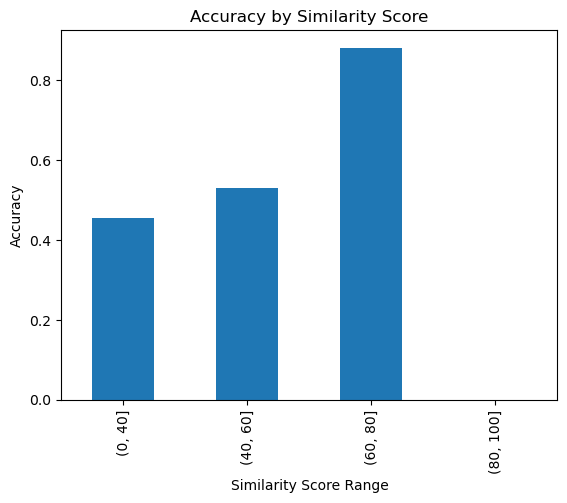

In [5]:
from matplotlib import pyplot as plt

# Bin similarity scores
bins = [0, 40, 60, 80, 100]
df["score_bin"] = pd.cut(df["similarity_scores"].apply(lambda x: x[0]), bins)
accuracy_by_score = df.groupby("score_bin")["is_correct"].mean()

print("Accuracy by Similarity Score Range:")
print(accuracy_by_score)

# Plot accuracy by similarity score
accuracy_by_score.plot(kind="bar", title="Accuracy by Similarity Score")
plt.xlabel("Similarity Score Range")
plt.ylabel("Accuracy")
plt.show()

**Analyze Incorrect Predictions and their description lengths**

Most Common Incorrect Matches with Description Lengths:
218999 - Other Services-Other Services (Count: 5101, Length: 29 characters)
213904 - Service for Other Supplies(OOE only) (Count: 3260, Length: 36 characters)
218601 - Other Services-Licences and Royalties (Count: 2716, Length: 37 characters)
213401 - Service for Uniform Supplies(OOE only) (Count: 2592, Length: 38 characters)
213201 - Service for Meals & Refreshments(OOE only) (Count: 2270, Length: 42 characters)
212501 - Rental-ICT Hardware (Count: 2002, Length: 19 characters)
213902 - Service for Industrial Supplies(OOE only) (Count: 1722, Length: 41 characters)
212401 - Rental-Other Equipment (Count: 1661, Length: 22 characters)
275201 - Fixed Asset Purchase-Office Equipment (Projcet) (Count: 1609, Length: 47 characters)
218901 - Other Services-Special Services (Count: 1538, Length: 31 characters)


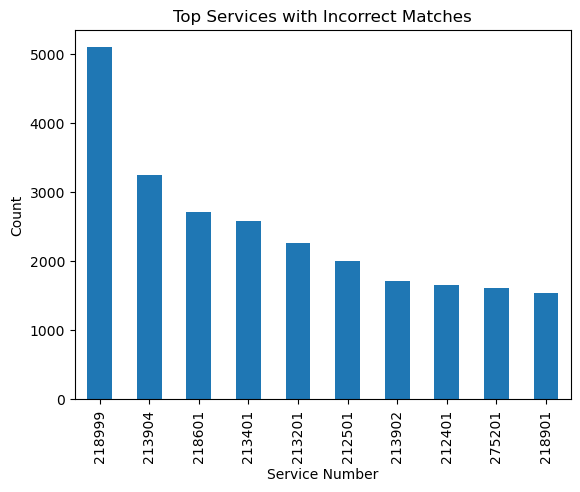

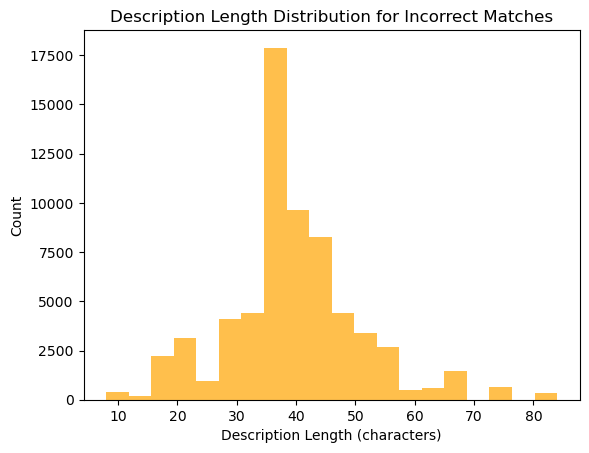

In [6]:
incorrect_df = df[~df["is_correct"]]

# Flatten the retrieved material numbers
incorrect_materials = incorrect_df.explode("retrieved_material_numbers")

def get_description_for_material(material_number, top_5_matches):
    for match in top_5_matches:
        if match["material_number"] == material_number:
            return match["description"]
    return "No description available"

incorrect_materials["retrieved_descriptions"] = incorrect_materials.apply(
    lambda row: get_description_for_material(row["retrieved_material_numbers"], row["retrieved_top_5"]),
    axis=1
)

# Add a column for description lengths
incorrect_materials["description_length"] = incorrect_materials["retrieved_descriptions"].apply(
    lambda desc: len(desc) if isinstance(desc, str) else 0
)

# Count the top incorrect material numbers
common_incorrect_matches = incorrect_materials["retrieved_material_numbers"].value_counts().head(10)

# Map to each material number
material_to_description = incorrect_materials.drop_duplicates("retrieved_material_numbers").set_index(
    "retrieved_material_numbers"
)[["retrieved_descriptions", "description_length"]].to_dict("index")

# print rows
print("Most Common Incorrect Matches with Description Lengths:")
for material_number, count in common_incorrect_matches.items():
    desc_info = material_to_description.get(material_number, {})
    description = desc_info.get("retrieved_descriptions", "No description available")
    desc_length = desc_info.get("description_length", 0)
    print(f"{material_number} - {description} (Count: {count}, Length: {desc_length} characters)")

# chart for top incorrect matches
common_incorrect_matches.plot(kind="bar", title="Top Services with Incorrect Matches")
plt.xlabel("Service Number")
plt.ylabel("Count")
plt.show()

# chart for description length distribution
incorrect_materials["description_length"].plot(kind="hist", bins=20, alpha=0.7, color="orange", title="Description Length Distribution for Incorrect Matches")
plt.xlabel("Description Length (characters)")
plt.ylabel("Count")
plt.show()

**Description length analysis for correct matches**

Most Common Correct Matches with Description Lengths:
218999 - Other Services-Other Manpower (Count: 1432, Length: 29 characters)
213904 - Service for Other Supplies(OOE only) (Count: 592, Length: 36 characters)
213201 - Service for Meals & Refreshments(OOE only) (Count: 447, Length: 42 characters)
218401 - Other Services-Postage and Courier Services (Count: 373, Length: 43 characters)
217401 - Tech Services-ICT Consultancy Services (Count: 366, Length: 38 characters)
213401 - Service for Uniform Supplies(OOE only) (Count: 361, Length: 38 characters)
218901 - Other Services-Special Services (Count: 350, Length: 31 characters)
223201 - Maintenance-Land Transport Facilities(OOE only) (Count: 261, Length: 47 characters)
213101 - Service for Office Supplies(OOE only) (Count: 187, Length: 37 characters)
212401 - Rental-Other Equipment (Count: 185, Length: 22 characters)


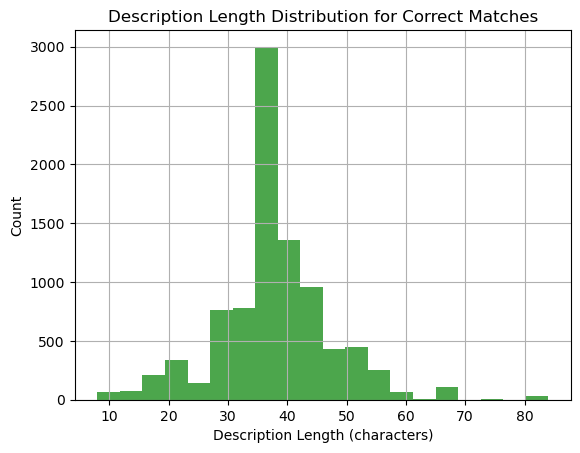

In [58]:
correct_df = df[df["is_correct"]]
correct_materials = correct_df.explode("retrieved_material_numbers")

correct_materials["retrieved_descriptions"] = correct_materials.apply(
    lambda row: get_description_for_material(row["retrieved_material_numbers"], row["retrieved_top_5"]),
    axis=1
)

# Add a column for description lengths
correct_materials["description_length"] = correct_materials["retrieved_descriptions"].apply(
    lambda desc: len(desc) if isinstance(desc, str) else 0
)

# Count the top correct material numbers
common_correct_matches = correct_materials["retrieved_material_numbers"].value_counts().head(10)

# Map to material numbers
material_to_description_correct = correct_materials.drop_duplicates("retrieved_material_numbers").set_index(
    "retrieved_material_numbers"
)[["retrieved_descriptions", "description_length"]].to_dict("index")

# print rows
print("Most Common Correct Matches with Description Lengths:")
for material_number, count in common_correct_matches.items():
    desc_info = material_to_description_correct.get(material_number, {})
    description = desc_info.get("retrieved_descriptions", "No description available")
    desc_length = desc_info.get("description_length", 0)
    print(f"{material_number} - {description} (Count: {count}, Length: {desc_length} characters)")

# chart of description lengths distribution
correct_materials["description_length"].hist(bins=20, alpha=0.7, color="green", label="Correct Matches")
plt.title("Description Length Distribution for Correct Matches")
plt.xlabel("Description Length (characters)")
plt.ylabel("Count")
#plt.legend()
plt.show()

**Query Length Analysis**

Accuracy by Query Length:
query_length_bin
(0, 50]       0.634783
(50, 100]     0.455878
(100, 150]    0.249831
(150, 200]    0.466326
Name: is_correct, dtype: float64


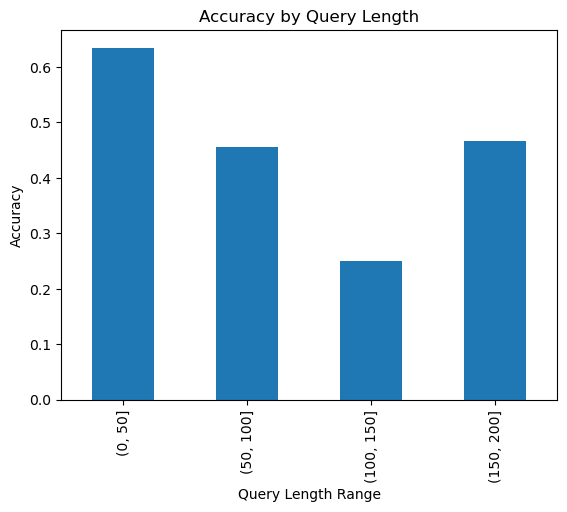

In [7]:
# Calculate query lengths
df["query_length"] = df["query"].apply(len)

# Group accuracy by query length ranges
bins = [0, 50, 100, 150, 200]
df["query_length_bin"] = pd.cut(df["query_length"], bins)
accuracy_by_length = df.groupby("query_length_bin")["is_correct"].mean()

print("Accuracy by Query Length:")
print(accuracy_by_length)

# Plot accuracy by query length
accuracy_by_length.plot(kind="bar", title="Accuracy by Query Length")
plt.xlabel("Query Length Range")
plt.ylabel("Accuracy")
plt.show()

NameError: name 'search_engine' is not defined